In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
np.random.seed(10)
random_dim = 100

In [3]:
# Load the MNIST dataset and normalize each pixel value to 0-1 range.
def load_mnist():
  (x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5
  x_train = x_train.reshape((-1,28,28,1))
  x_test = x_test.reshape((-1,28,28,1))
  return (x_train, y_train, x_test, y_test)

In [4]:
# Define a Generator
def define_generator(latent_dim):
  # takes 2 input: latent_vec and label
  # foundation of image
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=latent_dim))
  model.add(tf.keras.layers.Reshape((7,7,128)))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh'))
  
  # label encoding
  z = tf.keras.layers.Input(shape=(latent_dim,))
  label = tf.keras.layers.Input(shape=(1,),dtype='uint8')
  label_embed = tf.keras.layers.Embedding(10, latent_dim, input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  combined = tf.keras.layers.multiply([z, label_embed])

  img = model(combined)

  return tf.keras.models.Model([z, label], img)

latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
______________________________________________________________________________________________

In [5]:
# create a discriminator network to differentiate between real and fake image
def define_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(3,3),2,input_shape=(28,28,2),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))
    
  model.add(tf.keras.layers.Conv2D(64,(3,3),2,padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))
    
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  img = tf.keras.layers.Input(shape=(28, 28, 1))
  label = tf.keras.layers.Input(shape=(1,))
  label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28,28)), input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
  concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
  prediction = model(concatenated)
  return tf.keras.models.Model([img, label], prediction)
  
d_model = define_discriminator()
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_4[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           flatten_2[0][0]                  
____________________________________________________________________________________________

In [6]:
d_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
z = tf.keras.layers.Input(shape=(100,))
label = tf.keras.layers.Input(shape=(1,))
img = g_model([z, label])

d_model.trainable = False
prediction = d_model([img, label])
cgan = tf.keras.models.Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 28, 28, 1)    857193      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1633601     model[1][0]                

In [8]:
x_train, y_train, x_test, y_test = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step


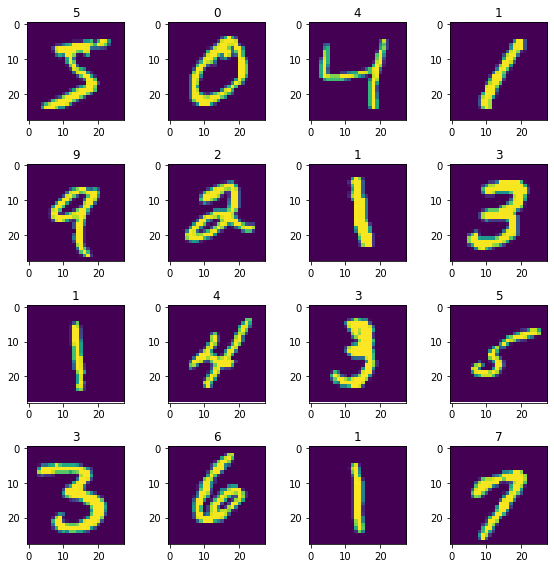

In [9]:
def plot_image(images, labels, rows, cols):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  for i in range(1, cols*rows +1):
      img = images[i-1]
      ax = fig.add_subplot(rows, cols, i)
      ax.title.set_text(labels[i-1])
      plt.imshow(img.reshape((28,28)))
  fig.tight_layout()
  plt.show()

samples = x_train[:4*4]
labels = y_train[:4*4]
plot_image(samples,labels, 4,4)

(60000, 28, 28, 1)
Losses(d,g): 0.7025397 [0.1633602, 1.0]


/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


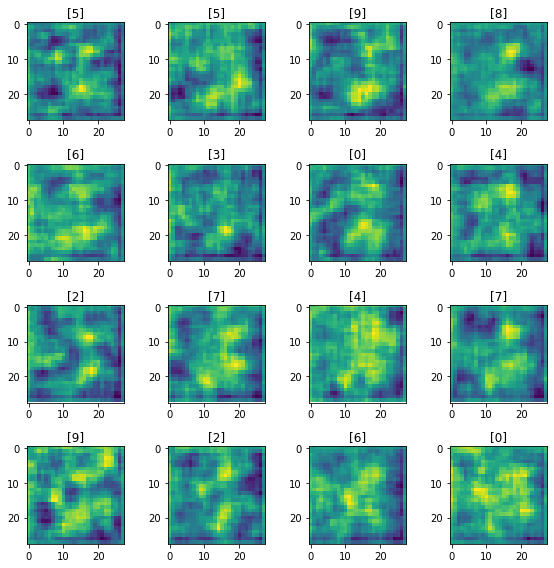

Losses(d,g): 0.0708877 [5.012157, 0.0]


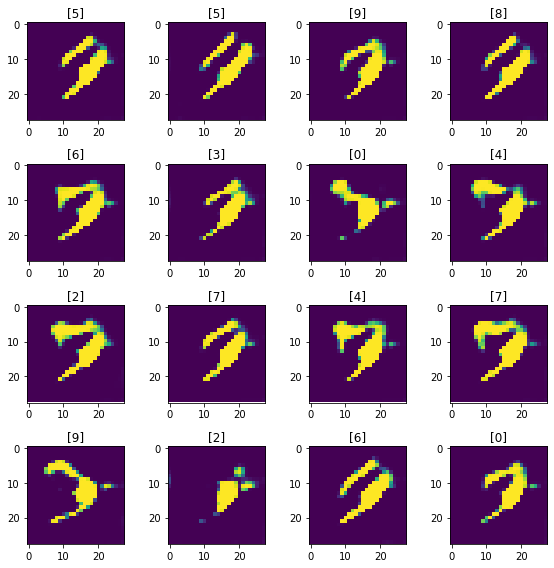

Losses(d,g): 0.37285277 [2.719708, 0.09375]


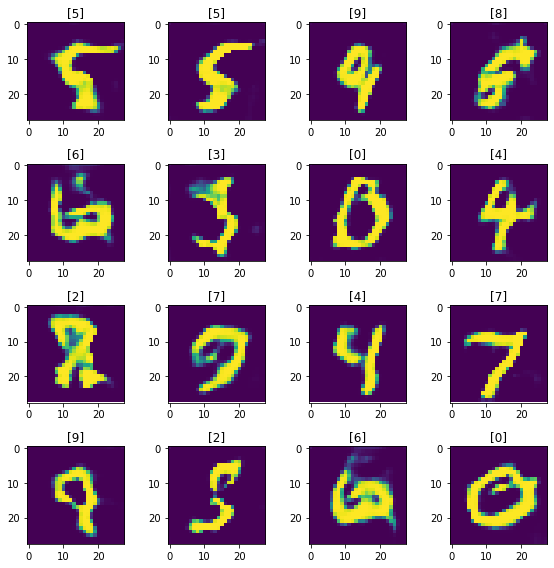

Losses(d,g): 0.55065197 [1.809582, 0.15625]


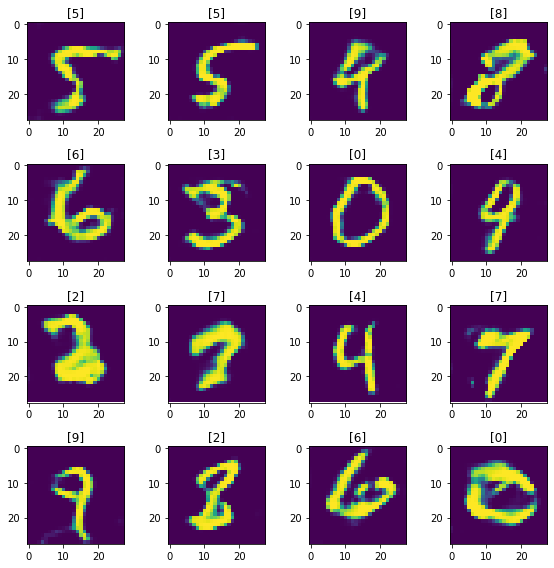

Losses(d,g): 0.51536024 [1.3073828, 0.265625]


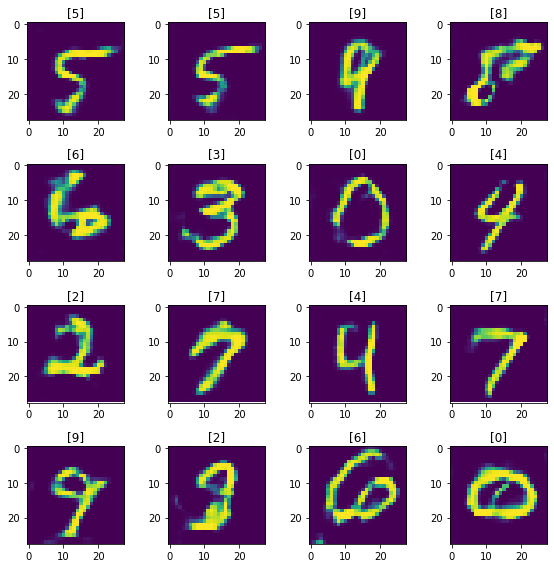

Losses(d,g): 0.5372976 [1.1409495, 0.203125]


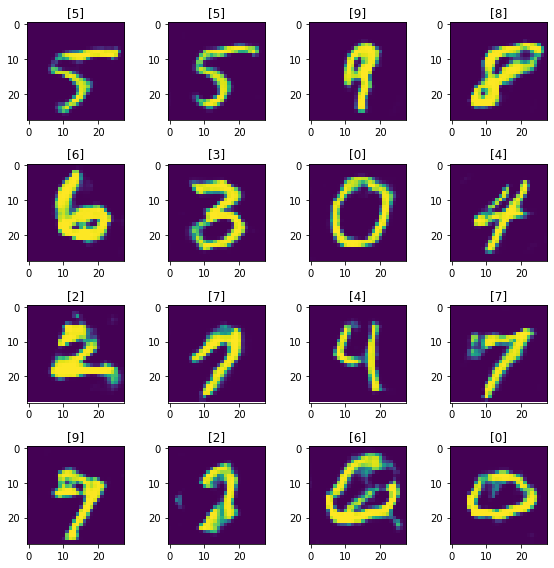

Losses(d,g): 0.5792544 [1.097344, 0.2890625]


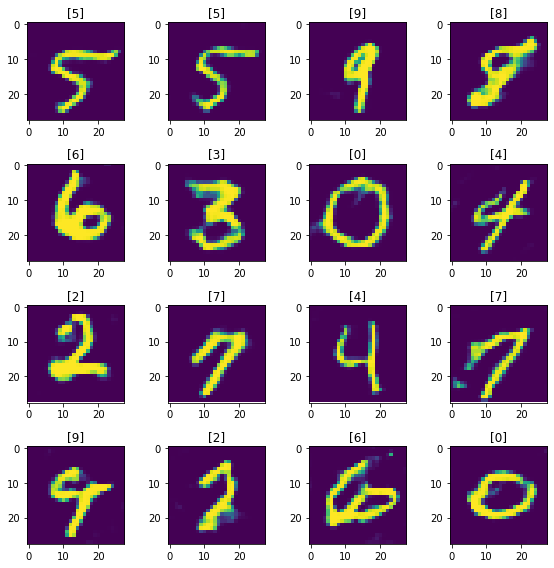

Losses(d,g): 0.5634681 [1.1543031, 0.2109375]


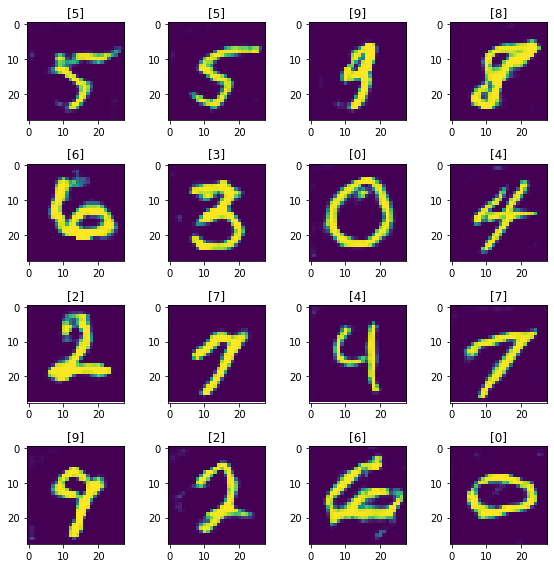

Losses(d,g): 0.59816605 [1.2031416, 0.1875]


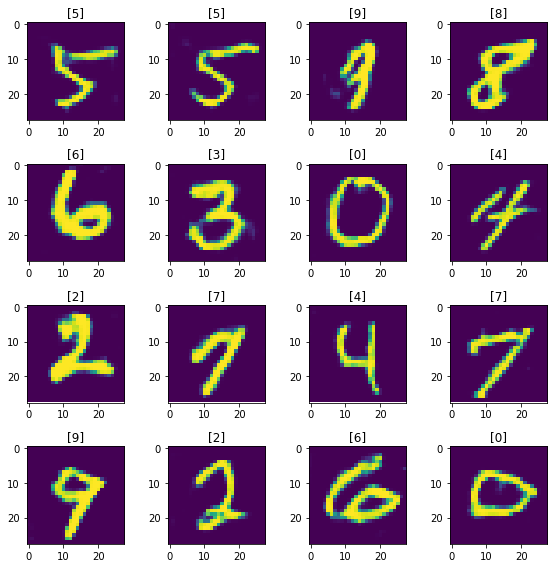

Losses(d,g): 0.61922866 [1.1520278, 0.2265625]


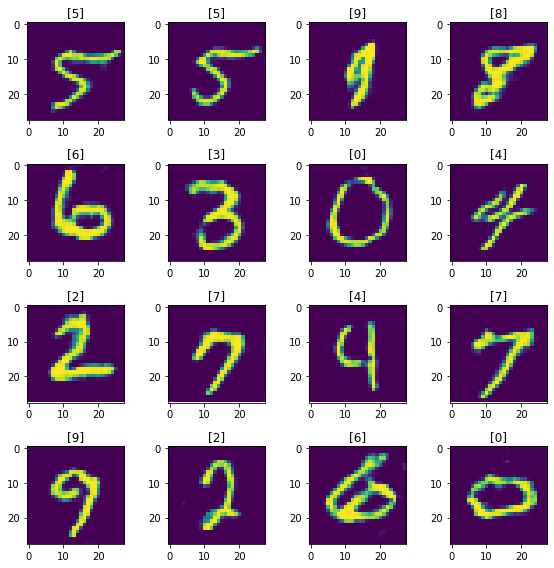

Losses(d,g): 0.60577106 [0.9145649, 0.328125]


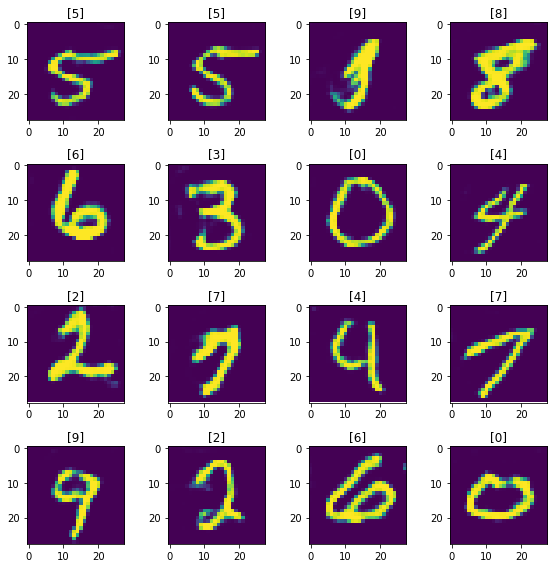

Losses(d,g): 0.5076067 [1.3919437, 0.15625]


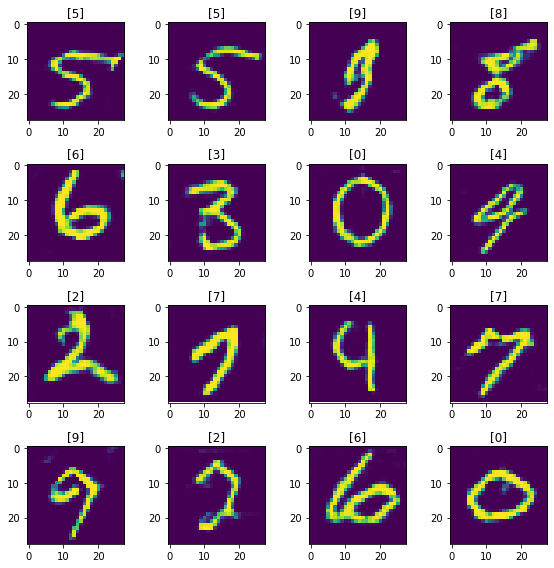

Losses(d,g): 0.5881736 [1.1044955, 0.265625]


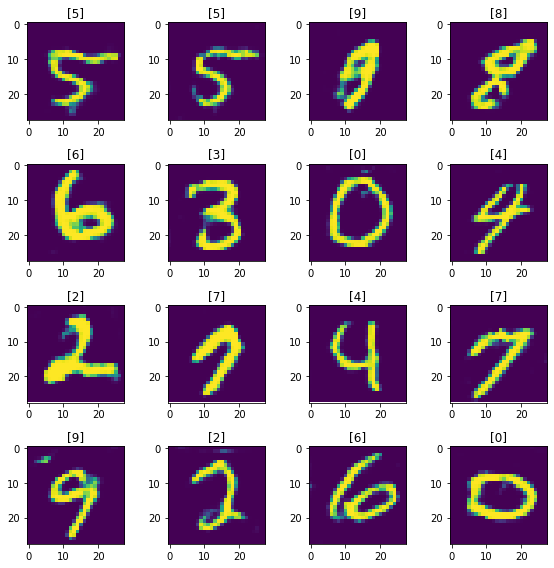

Losses(d,g): 0.5778736 [1.1045184, 0.265625]


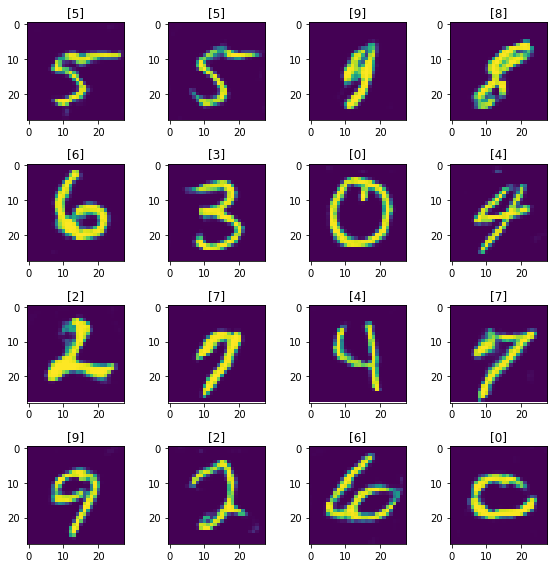

Losses(d,g): 0.6290135 [1.0925877, 0.25]


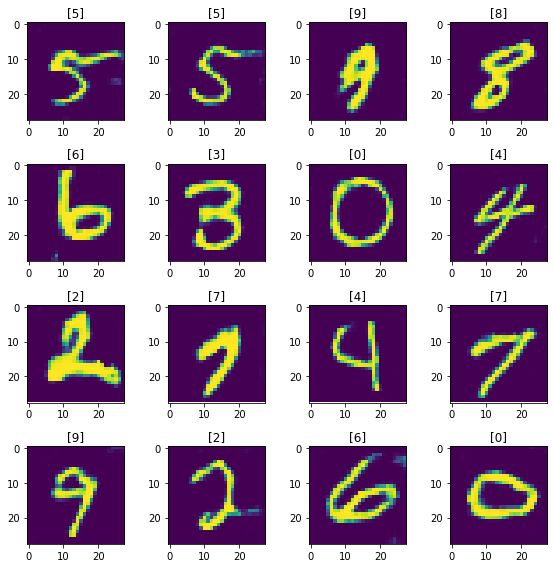

Losses(d,g): 0.6004345 [0.9825719, 0.3828125]


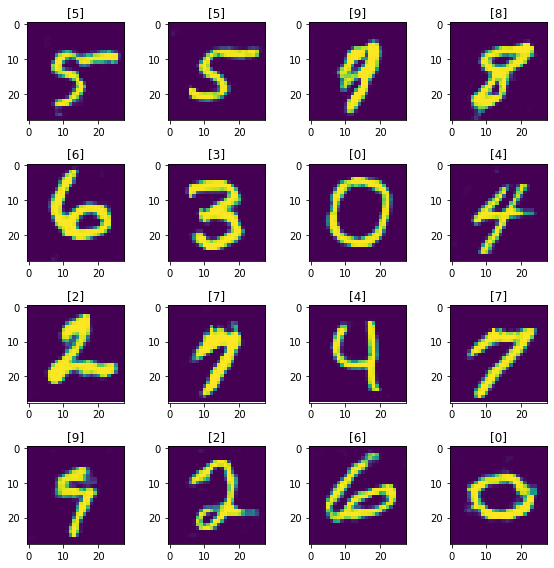

In [10]:
import os 

epochs = 15005
batch_size = 128
save_interval = 1000

print(x_train.shape)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

losses = {"G":[], "D":[]}

samples_test = np.random.normal(0,1,(16, 100))
labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))

for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs, labels = x_train[idx], y_train[idx]
    
    noise = np.random.normal(0,1,(batch_size, 100))
    fake_imgs = g_model.predict([noise, labels])
    
    # train discriminator
    d_model.trainable = True
    d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
    d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    d_model.trainable = False
    
    z = np.random.normal(0,1, size=(batch_size, 100))
    labels = np.random.randint(0, 10, batch_size).reshape((-1, 1))

    # train generator
    g_loss = cgan.train_on_batch([z, labels], valid)
    
    losses["G"].append(g_loss)
    losses["D"].append(d_loss)
    
    if epoch % save_interval == 0:
        print("Losses(d,g):", d_loss[0], g_loss)
        results = g_model.predict([samples_test, labels_test])
        plot_image(results, labels_test, 4, 4)

In [11]:
d_model.save('discriminator.h5')
g_model.save('generator.h5')
cgan.save('cgan.h5')